In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
file_path = "/Users/macbookpro/Downloads/digital_wallet_transactions.csv"

tx = pd.read_csv(file_path, parse_dates=['transaction_date'])
customer = pd.read_csv(file_path)

tx.head()
customer.head()


,idx,transaction_id,user_id,transaction_date,product_category,product_name,merchant_name,product_amount,transaction_fee,cashback,loyalty_points,payment_method,transaction_status,merchant_id,device_type,location
0,1,4dac3ea3-6492-46ec-80b8-dc45c3ad0b14,USER_05159,2023-08-19 03:32,Rent Payment,2BHK Flat Deposit,Airbnb,1525.39,36.69,19.19,186,Debit Card,Successful,MERCH_0083,iOS,Urban
1,2,a903ed9f-eb84-47e7-b8aa-fd1786c919cf,USER_07204,2023-08-19 04:37,Gas Bill,Commercial Gas Connection,Adani Gas,1495.40,28.19,89.99,182,UPI,Successful,MERCH_0163,iOS,Urban
2,3,2a393013-733c-4add-9f09-bed1eeb33676,USER_00903,2023-08-19 05:52,Bus Ticket,Semi-Sleeper,MakeMyTrip Bus,1267.71,11.36,95.70,994,UPI,Successful,MERCH_0320,iOS,Urban
3,4,9a07ad19-4673-4794-9cd2-9b139f39c715,USER_01769,2023-08-19 06:35,Internet Bill,4G Unlimited Plan,Airtel Broadband,9202.63,6.41,82.24,409,Debit Card,Successful,MERCH_0194,Android,Urban
4,5,76418260-c985-4011-979d-0914604d0d68,USER_03544,2023-08-19 06:36,Loan Repayment,Home Loan EMI,Axis Bank,3100.58,41.15,40.47,837,Debit Card,Successful,MERCH_0504,Android,Urban


In [3]:
tx.isna().sum()
customer.isna().sum()

idx                   0
transaction_id        0
user_id               0
transaction_date      0
product_category      0
product_name          0
merchant_name         0
product_amount        0
transaction_fee       0
cashback              0
loyalty_points        0
payment_method        0
transaction_status    0
merchant_id           0
device_type           0
location              0
dtype: int64

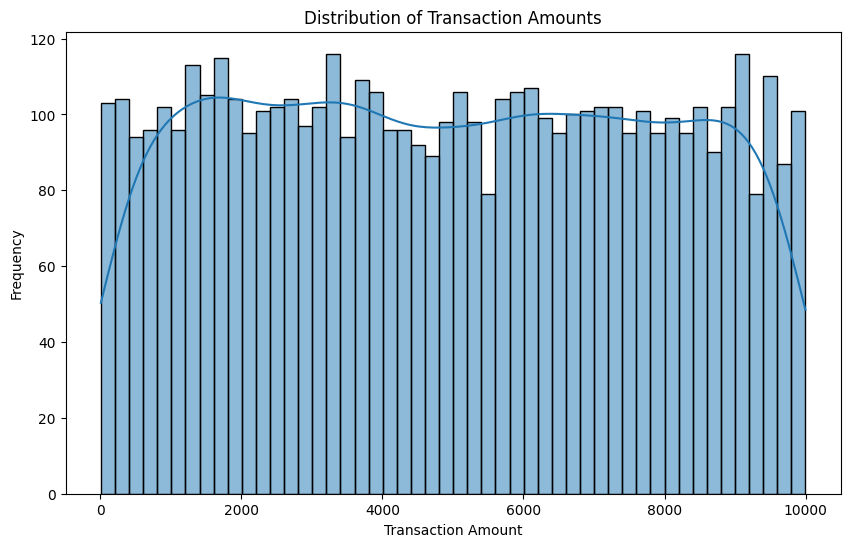

In [4]:
# Distribution of transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(tx['product_amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

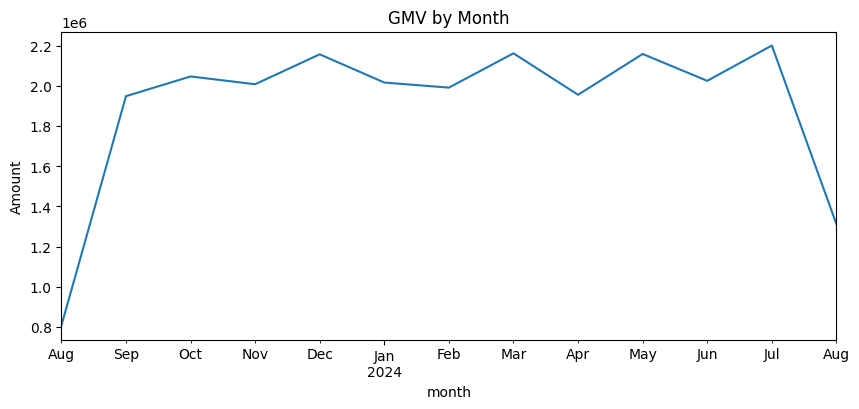

In [5]:
# GMV by month 
tx['month']=tx['transaction_date'].dt.to_period('M')
monthly_gmv = tx.groupby('month')['product_amount'].sum()
monthly_gmv.plot(kind='line', figsize=(10,4))
plt.title("GMV by Month")
plt.ylabel("Amount")
plt.show()

In [ ]:
# Cohort Retention
signup = tx.groupby('user_id')['transaction_date'].min().reset_index()
signup.columns = ['user_id', 'signup_date']
tx = tx.merge(signup, on='user_id', how='left')

tx['cohort_month'] = tx['signup_date'].dt.to_period('M')
tx['active_month'] = tx['transaction_date'].dt.to_period('M')
tx['month_offset'] = (tx['active_month'] - tx['cohort_month']).apply(lambda x: x.n)

cohort = tx.groupby(['cohort_month', 'month_offset'])['user_id'].nunique().reset_index()
cohort_pivot = cohort.pivot(index='cohort_month', columns = 'month_offset', values = 'user_id')
# Retention rate 
cohort_retention = cohort_pivot.divide(cohort_pivot[0], axis=0)
print (cohort_retention)

month_offset   0         1         2         3         4         5         6   \
cohort_month                                                                    
2023-08       1.0  0.029762  0.065476  0.035714  0.041667  0.059524  0.053571   
2023-09       1.0  0.039702  0.032258  0.049628  0.034739  0.044665  0.034739   
2023-10       1.0  0.047120  0.047120  0.034031  0.028796  0.047120  0.036649   
2023-11       1.0  0.036313  0.050279  0.058659  0.041899  0.030726  0.050279   
2023-12       1.0  0.049861  0.024931  0.044321  0.033241  0.030471  0.033241   
2024-01       1.0  0.030675  0.024540  0.049080  0.033742  0.046012  0.036810   
2024-02       1.0  0.025890  0.038835  0.038835  0.045307  0.042071  0.038835   
2024-03       1.0  0.033333  0.033333  0.042424  0.042424  0.012121       NaN   
2024-04       1.0  0.059859  0.049296  0.028169  0.035211       NaN       NaN   
2024-05       1.0  0.053459  0.028302  0.031447       NaN       NaN       NaN   
2024-06       1.0  0.026616 

In [10]:
#RFM
snapshot_date = tx['transaction_date'].max()
rfm = tx.groupby('user_id').agg({
    'transaction_date': lambda x: (snapshot_date - x.max()).days,
    'transaction_id': 'count',
    'product_amount': 'sum'
}).reset_index()

rfm.rename(columns={
    'transaction_date': 'Recency',
    'transaction_id': 'Frequency',
    'product_amount': 'Monetary'
}, inplace=True)

In [11]:
#Churn
rfm['Churn'] = (rfm['Recency'] > 30).astype(int)
X = rfm[['Recency','Frequency','Monetary']]
y = rfm['Churn']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
pred = model.predict(X_test)

print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       103
           1       1.00      1.00      1.00       684

    accuracy                           1.00       787
   macro avg       1.00      1.00      1.00       787
weighted avg       1.00      1.00      1.00       787

